In [8]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.spatial import distance

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

In [9]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]
def remove_noise(binary_image):
    ret_val = erode(dilate(binary_image))
    ret_val = invert(ret_val)
    return ret_val

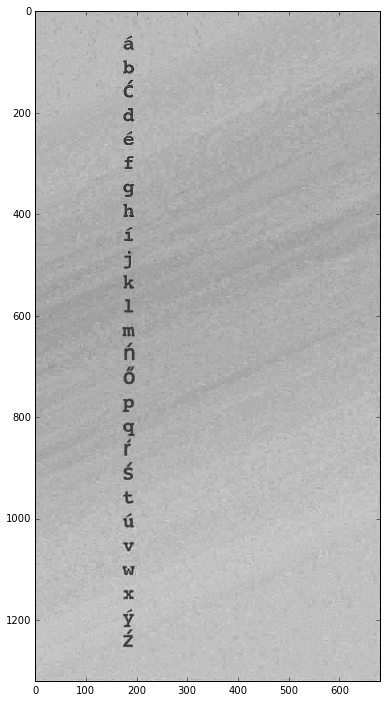

In [10]:
image=load_image('images/fifi_train.jpg')
from IPython.html import widgets
from IPython.html.widgets import interactive
from IPython.display import display
height, width = image.shape[0:2]
# ndarray je n-dimensional array, odnosno n-dimenzionalna matrica. Grayscale slika nema RGB, 
# vec samo intenzitet piksela (0 je crno, 255 je belo, sve ostalo izmedju je nijansa sive).
# Sa dtype=np.uint8 se naglasava da je u pitanju 8-bitni tip podatka za elemente matrice, tj. piksele
image_gray = np.ndarray((height, width), dtype=np.uint8)


#def rgb(r,g,b):
for i in range(0, height):
    for j in range(0, width):
        pixel = image[i, j] # preuzimanje piksela
        re,gr,bl = pixel[0], pixel[1], pixel[2] # preuzimanje RGB komponenti piksela
        gray = float(re) * 0 + float(gr) * 0.039 + float(bl) *1 # racunanje grayscale intenziteta
        image_gray[i, j] = gray # postavljanje piksela na rezultujucoj slici

plt.imshow(image_gray, 'gray')

#r_slider = widgets.FloatSliderWidget(min=0,max=1,value=0.5,step=0.001)
#g_slider = widgets.FloatSliderWidget(min=0,max=1,value=0.5,step=0.001)
#b_slider = widgets.FloatSliderWidget(min=0,max=1,value=0.5,step=0.001)
#w = widgets.interactive(rgb, r=r_slider, g=g_slider, b=b_slider)
#display(w)

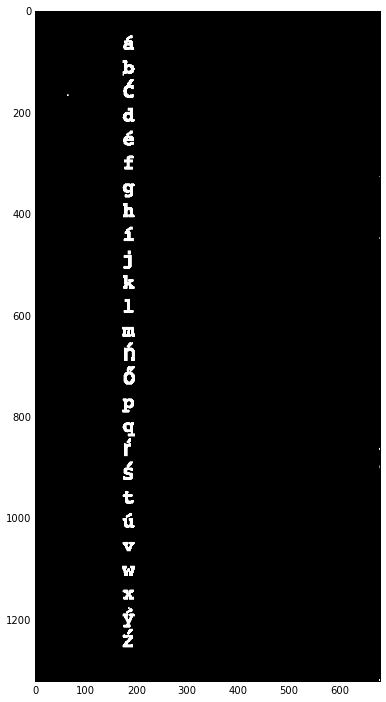

In [11]:
from scipy import signal
gx = [[-1, 0, 1],
     [-2, 0, 2],
     [-1, 0, 1]]

gy = [[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]]

image_gx = signal.convolve2d(image_gray, gx)
image_gy = signal.convolve2d(image_gray, gy)
image_sobel = np.sqrt(image_gx*image_gx + image_gy*image_gy)
#plt.imshow(image_sobel, 'gray')

image_b= image_bin_adaptive(image_gray)
image_b =invert(erode(image_b))
display_image(image_b)

In [12]:
def rotate_regions(contours,angles,centers,sizes):
    '''Funkcija koja vrši rotiranje regiona oko njihovih centralnih tačaka
    Args:
        contours: skup svih kontura [kontura1, kontura2, ..., konturaN]
        angles:   skup svih uglova nagiba kontura [nagib1, nagib2, ..., nagibN]
        centers:  skup svih centara minimalnih pravougaonika koji su opisani 
                  oko kontura [centar1, centar2, ..., centarN]
        sizes:    skup parova (height,width) koji predstavljaju duzine stranica minimalnog
                  pravougaonika koji je opisan oko konture [(h1,w1), (h2,w2), ...,(hN,wN)]
    Return:
        ret_val: rotirane konture'''
    ret_val = []
    for idx, contour in enumerate(contours):
                
        angle = angles[idx]
        cx,cy = centers[idx]
        height, width = sizes[idx]
        if width<height:
            angle+=90
            
        # Rotiranje svake tačke regiona oko centra rotacije
        alpha = np.pi/2 - abs(np.radians(angle))
        region_points_rotated = np.ndarray((len(contour), 2), dtype=np.int16)
        for i, point in enumerate(contour):
            x = point[0]
            y = point[1]
            
            #TODO 1 - izračunati koordinate tačke nakon rotacije
            rx = np.sin(alpha)*(x-cx) - np.cos(alpha)*(y-cy) + cx
            ry = np.cos(alpha)*(x-cx) + np.sin(alpha)*(y-cy) + cy
            
            
            region_points_rotated[i] = [rx,ry]
        ret_val.append(region_points_rotated)
        

    return ret_val

In [13]:
def merge_regions(contours):
    '''Funkcija koja vrši spajanje kukica i kvačica sa osnovnim karakterima
    Args:
        contours: skup svih kontura (kontura - niz tacaka bele boje)
    Return:
        ret_val: skup kontura sa spojenim kukicama i kvacicama'''
    ret_val = []
    merged_index = [] #lista indeksa kontura koje su već spojene sa nekim

    for i,contour1 in enumerate(contours): #slova
        if i in merged_index:
            continue
        min_x1 = min(contour1[:,0])
        max_x1 = max(contour1[:,0])
        min_y1 = min(contour1[:,1])
        max_y1 = max(contour1[:,1])
        for j,contour2 in enumerate(contours): #kukice
            if j in merged_index or i == j:
                continue
            min_x2 = min(contour2[:,0])
            max_x2 = max(contour2[:,0])
            min_y2 = min(contour2[:,1])
            max_y2 = max(contour2[:,1])
            
            #TODO 2 - izvršiti spajanje kukica iznad slova
            #spajanje dva niza je moguće obaviti funkcijom np.concatenate((contour1,contour2))
            
            if len(contour1)>len(contour2)*10: #provera pretpostavke da je contour1 slovo
                
                if (min_y1-max_y2)<max(max_y1-min_y1,max_y2-min_y2)/2 \
                and (min_x2>min_x1-5 and max_x2<max_x1+5):
                    #spajanje kontura
                    ret_val.append(np.concatenate((contour1,contour2)))
                    merged_index.append(i)
                    merged_index.append(j)
            
                    
    #svi regioni koji se nisu ni sa kim spojili idu u listu kontura, bez spajanja
    for idx,contour in enumerate(contours):
        if idx not in merged_index:
            ret_val.append(contour)
        
    return ret_val


In [14]:
def select_roi(image_orig, image_bin):
    
    img, contours_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    contours = []
    contour_angles = []
    contour_centers = []
    contour_sizes = []
    for contour in contours_borders:
        center, size, angle = cv2.minAreaRect(contour)
        xt,yt,w,h = cv2.boundingRect(contour)   
        #cv2.boxPoint(cv2.minAreaRect(countour)) drawContour
        if w>9 and h>10:
            region_points = []
            for i in range (xt,xt+h):
                for j in range(yt,yt+w):
                    dist = cv2.pointPolygonTest(contour,(i,j),False)
                    if dist>=0 and image_bin[j,i]==255: # da li se tacka nalazi unutar konture?
                        region_points.append([i,j])
            cv2.rectangle(image_orig,(xt,yt),(xt+w,yt+h),(0,255,0),2)
            contour_centers.append(center)
            contour_angles.append(angle)
            contour_sizes.append(size)
            contours.append(region_points)
            
    
    #Postavljanje kontura u vertikalan polozaj
    contours = rotate_regions(contours, contour_angles, contour_centers, contour_sizes)
    
    #spajanje kukica i kvacica
    contours = merge_regions(contours)
    
    regions_dict = {}
    for contour in contours:
    
        min_x = min(contour[:,0])
        max_x = max(contour[:,0])
        min_y = min(contour[:,1])
        max_y = max(contour[:,1])

        region = np.zeros((max_y-min_y+1,max_x-min_x+1), dtype=np.int16)
        for point in contour:
            x = point[0]
            y = point[1]
            
             # TODO 3 - koordinate tacaka regiona prebaciti u relativne koordinate
            '''Pretpostavimo da gornja leva tačka regiona ima apsolutne koordinate (100,100).
            Ako uzmemo tačku sa koordinatama unutar regiona, recimo (105,105), nakon
            prebacivanja u relativne koordinate tačka bi trebala imati koorinate (5,5) unutar
            samog regiona.
            '''
            region[y-min_y,x-min_x] = 255

        
        regions_dict[min_y] = [resize_region(region), (min_x,min_y,max_x-min_x,max_y-min_y)]  #min_y
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][1]-sorted_rectangles[0][3]]
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += y
        region_distances.append(-y-h)
    region_distances[-1] += sorted_rectangles[-1][1]
    
    return image_orig, sorted_regions[:, 0], region_distances

26


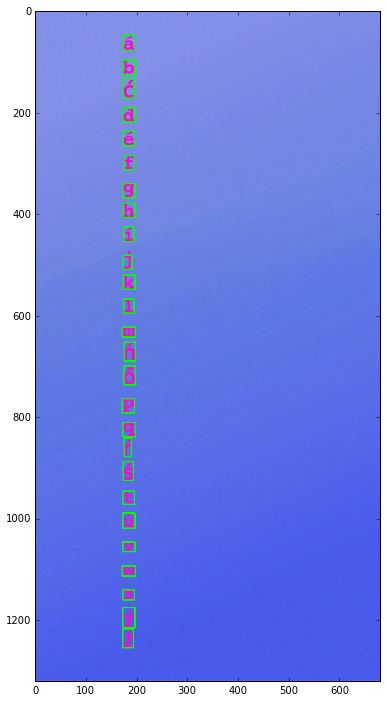

In [15]:
selected_reg, letters, distances = select_roi(image.copy(), image_b)
display_image(selected_reg)
print len(letters)

In [16]:
def create_ann(output):
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

In [17]:
alfabet = ['A','B','Ć','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
distances = np.array(distances).reshape(len(distances), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(distances)
inputs = prepare_for_ann(letters)
outputs = convert_output(alfabet)
ann = create_ann(len(alfabet))
ann = train_ann(ann, inputs, outputs)

In [18]:
def display_result(outputs, alphabet, k_means):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    # Odrediti indeks grupe koja odgovara rastojanju između reči, pomoću vrednosti iz k_means.cluster_centers_
    w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    h_space_group = max(enumerate(k_means.cluster_centers_), key = lambda y: y[1])[0]
    result = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:,:]):
        # Iterativno dodavati prepoznate elemente kao u vežbi 2, alphabet[winner(output)]
        # Dodati space karakter u slučaju da odgovarajuće rastojanje između dva slova odgovara razmaku između reči.
        # U ovu svrhu, koristiti atribut niz k_means.labels_ koji sadrži sortirana rastojanja između susednih slova.
        if (k_means.labels_[idx] == w_space_group):
            result += ' '
        #elif (k_means.labels_[idx] == h_space_group):
            #result = ' '
        result += alphabet[winner(output)]
    return result

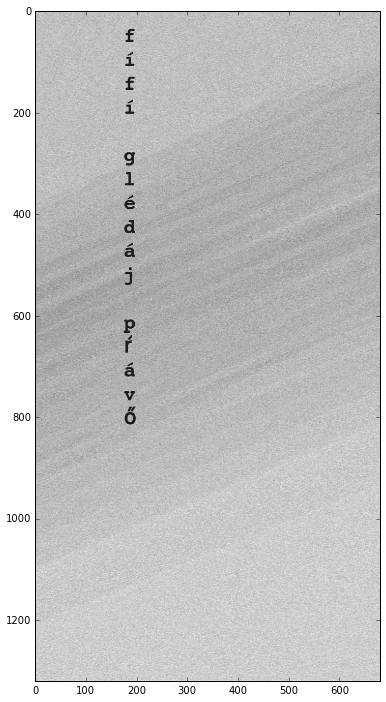

In [19]:
image_test=load_image('images/fifi_test.jpg')
#from IPython.html import widgets
#from IPython.html.widgets import interactive
#from IPython.display import display
height, width = image.shape[0:2]
# ndarray je n-dimensional array, odnosno n-dimenzionalna matrica. Grayscale slika nema RGB, 
# vec samo intenzitet piksela (0 je crno, 255 je belo, sve ostalo izmedju je nijansa sive).
# Sa dtype=np.uint8 se naglasava da je u pitanju 8-bitni tip podatka za elemente matrice, tj. piksele
image_gray_test = np.ndarray((height, width), dtype=np.uint8)


#def rgb(r,g,b):
for i in range(0, height):
    for j in range(0, width):
        pixel = image_test[i, j] # preuzimanje piksela
        re,gr,bl = pixel[0], pixel[1], pixel[2] # preuzimanje RGB komponenti piksela
        gray = float(re) * 0 + float(gr) * 0.039 + float(bl) *1 # racunanje grayscale intenziteta
        image_gray_test[i, j] = gray # postavljanje piksela na rezultujucoj slici

plt.imshow(image_gray_test, 'gray')


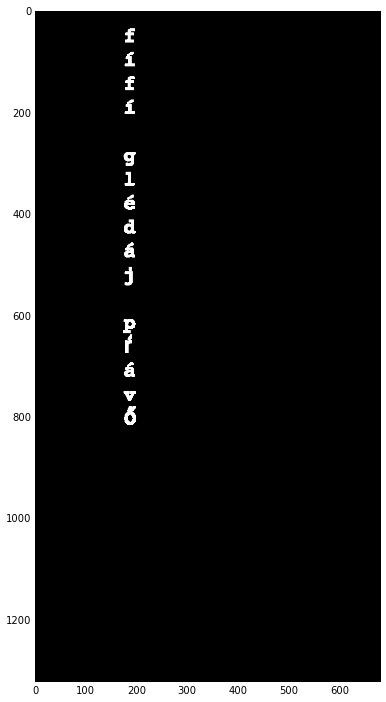

In [20]:
image_b_test= image_bin_adaptive(image_gray_test)
image_b_test =invert(erode(image_b_test))
display_image(image_b_test)

[27, 29, 27, 84, 16, 26, 28, 23, 36, 79, 6, 41, 34, 13]


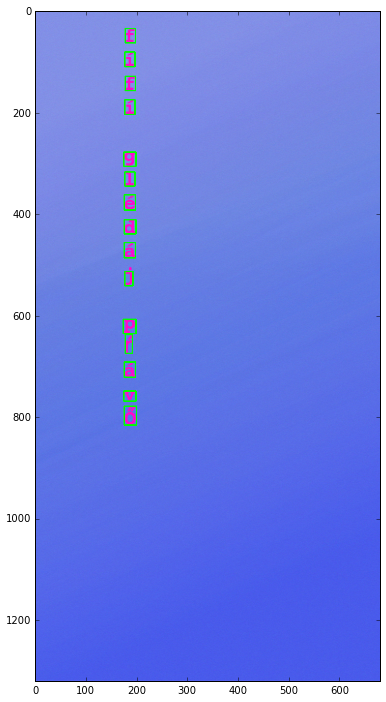

In [21]:
selected_regions_test, letters_test, region_distances_test = select_roi(image_test.copy(), image_b_test)
display_image(selected_regions_test)
print region_distances_test

In [22]:
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)
inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32))
print display_result(results_test, alfabet, k_means_test)

FIFI GLEDAJ PRAVO
